In [6]:
import numpy as np 
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy import signal
%matplotlib inline

In [4]:
class telescope(object):
    """
    Object to store the properties of the telescope, including:
    ---Telescope location
    ---Array configuration
    ---Primary beam
    """
    def __init__(self, ant_locs, latitude, channel_width, Tsys, beam_width, beam='gaussian'):
        self.ant_locs = ant_locs # (Nants,2) sized array # relative position in meters 
        self.latitude = latitude # degrees this is the central latitute of the HERA strip 
        self.latitude *= np.pi / 180. # radians
        self.channel_width = channel_width # assume Hz
        self.Tsys = Tsys # assume Kelvin
        if beam != 'gaussian':
            raise NotImplementedError()
        else:
            self.beam = beam
            self.beam_width = beam_width # FWHM in degrees
            self.beam_width *= np.pi / 180. # FWHM in radians


    def compute_2D_bls(self):
        """
        Computes the 2D ("uv plane") baselines for a local coordinate
        system when the observations started.
        """
        N_ants = self.ant_locs.shape[0]
        N_bls = int(N_ants * (N_ants - 1) / 2)
        self.bls = np.zeros((N_bls,2)) # initialize a list holding the length of all the baselines 
        k = 0 #initialize this k variable
        for i in range(N_ants):
            ant_i = self.ant_locs[i]
            for j in range(i+1,N_ants):
                ant_j = self.ant_locs[j]
                self.bls[k] = ant_i - ant_j # this subtracts each coordinate from the other [0,0]-[1,1]
                k += 1 #add k every time you identify a baseline which is every 

    def remove_redundant_bls(self):
        """
        Removes redundant baselines. Information is preserved by
        storing a multiplicity array.
        """
        self.compute_2D_bls()
        self.bls, self.ucounts = np.unique(self.bls, axis=0, return_counts=True)
        self.N_bls= len(self.bls) # number of unique pairs of baselines
        
        return len(self.bls)


    def compute_celestial_bls(self):
        """
        Computes a 3D distribution of baselines in a coordinate
        system fixed to the celestial sphere.
        """
        # First define the rotation matrix that gets baselines
        # to the correct latitude for the array
        self.remove_redundant_bls()
        
        co_lat = np.pi / 2. - self.latitude
        cos_co_lat = np.cos(co_lat)
        sin_co_lat = np.sin(co_lat)
        lat_rot_matrix = np.array([[1., 0., 0.],
                                  [0., cos_co_lat, -sin_co_lat],
                                  [0., sin_co_lat, cos_co_lat]])


        # Add a z coordinate to the 2D baseline vectors
        self.bls_celestial = np.vstack((self.bls.T, np.zeros(self.N_bls)))
        # Rotate them!
        self.bls_celestial = np.dot(lat_rot_matrix, self.bls_celestial)
        return self.bls_celestial


class observation(object):
    """
    Object that stores all the sky information 
    """

    def __init__(self, telescope, n_days, freq, delta_t, corners, effarea, beam_sigma_cutoff, resol):
        self.times = None # in days
        self.position = None# observable corners (theta, phi)
        self.bl_times = None
        self.norm = None
        self.corners = corners# corners has to be the four corner of the sky (theta, phi) [4,2]
        self.beam_sigma_cutoff = beam_sigma_cutoff
        self.telescope = telescope
        self.n_days = n_days # Number of cycles of the observation
        self.delta_t = delta_t
        self.effarea = effarea # Effective area of an antenna
        
        self.beam_width = telescope.beam_width
        self.beam = telescope.beam
        self.ant_locs = telescope.ant_locs
        self.latitude = telescope.latitude
        self.channel_width = telescope.channel_width
        self.Tsys = telescope.Tsys
        self.bls_celestial = telescope.compute_celestial_bls()
        self.ucounts = telescope.ucounts # number of unique baselines
        
        self.freq = freq #MHz
        self.resol = resol # deg
        self.resol *= np.pi/180
        
        self.Nbl = self.bls_celestial.shape[1]
        

    def observable_coordinates(self):
        """
        Find the observable coordinates given the four corners of a patch
        """
        s = self.corners.shape
        if s[0] != 4:
            raise ValueError('Four coordinates should be provided')
        elif s[1] != 2:
            raise ValueError('Input has to be RA & Dec')
            
        beam_minus, beam_plus = np.array([-1, +1])*self.beam_width*self.beam_sigma_cutoff
        min_corner = np.min(self.corners, axis=0)
        max_corner = np.max(self.corners, axis=0)
        min_obsbound = self.latitude + beam_minus #Here we're computing the size of the observing window
        max_obsbound = self.latitude + beam_plus #bigger beam_width or sigma_cutoff means a larger observing window 

        
        if max_corner[0]*(np.pi/180) < min_obsbound or min_corner[0]*(np.pi/180) > max_obsbound:
            raise ValueError('Requested Region is not observable')
        else:
            thetas = np.arange(min_obsbound, max_obsbound, self.resol)
            phis = np.arange((min_corner[1]*(np.pi/180)), (max_corner[1]*(np.pi/180)), self.resol)
            self.position = np.concatenate(np.dstack(np.meshgrid(thetas, phis)))
            self.Npix = self.position.shape[0]
            
            
        return self.position
        

    def necessary_times(self):
        """
        Assuming Phi = 0h at phi coordinate of observable region(self.potion), 
        Figure out time when the telescope scanning and observable region overlaps
        """

        if self.position is not None:
            pass
        else:
            self.position = self.observable_coordinates() 

        time_length = (np.max(self.position[:,1]) - np.min(self.position[:,1])) / (2*np.pi)
        self.times = np.arange(0, time_length, self.delta_t)
        self.Nt = len(self.times)
        return self.times
    


    # def time_to_phi(self, times):
    #     """
    #     Given an observation time since the beginning of observations,
    #     computes the angle by which the Earth has rotated.

        
    #     Parameters
    #     ----------
    #     times : array of floats
    #         Time since the beginning of observations in days.

    #     Returns
    #     -------
    #     scalar: array of float
    #         Angle rotated since beginning of observations.
    #     """
    #     return 2. * np.pi * times

    def rotate_bls(self):
        """
        Rotates the baselines to their correct positions given
        the observation times. Results are stored in a bl-time array.
        """

        if self.times is not None:
            pass
        else:
            self.times = self.necessary_times()
        phis = 2. * np.pi * self.times # Times are assumed to be in days

        # Define rotation matrices about z axis
        cos_phis = np.cos(phis)
        sin_phis = np.sin(phis)
        time_rot_matrices = np.zeros((self.times.shape[0], 3, 3))
        time_rot_matrices[:,-1,-1] = 1.
        for i in range(self.times.shape[0]):
            time_rot_matrices[i,0,0] = cos_phis[i]
            time_rot_matrices[i,0,1] = -sin_phis[i]
            time_rot_matrices[i,1,0] = sin_phis[i]
            time_rot_matrices[i,1,1] = cos_phis[i]

        # Multiply baselines by rotation matrices
        # Result is a N_times x 3 x N_bls matrix
        
        self.bl_times = np.dot(time_rot_matrices, self.bls_celestial)
        self.bl_times = np.moveaxis(self.bl_times, -1, 0) # now N_bls x N_t x 3
        self.bl_times = np.reshape(self.bl_times, (-1,3)) # now N_bl N_t x 3
        
        return self.bl_times.shape

    def convert_to_3d(self):
        """
        Project the patch of the sky (Equatorial coord) onto 
        the baseline coordinate (3D) for calibration
        """
        
        if self.position is not None:
            pass
        else:
            self.observable_coordinates()
        
        thetas = self.position[:,0]
        phis = self.position[:,1]
        transformed = np.zeros((self.Npix, 3))
        for i in range(self.Npix):
            transformed[i,0] = np.sin(thetas[i])*np.cos(phis[i])
            transformed[i,1] = np.sin(thetas[i])*np.sin(phis[i])
            transformed[i,2] = np.cos(thetas[i])
            
        return transformed
        
    
    def compute_bdotr(self):
        """
        Given an array of times and sky positions,
        computes an (N_times,N_pos) array
        containing b-dot r.
        """

        if self.bl_times is not None:
            pass
        else:
            self.rotate_bls()
        
        position3d = self.convert_to_3d()   

        # Result is a N_t N_bl x N_pix array
        self.bdotr = np.dot(self.bl_times, position3d.T)


    def compute_beam(self):
        """
        Compute Primary Beam assuming all antenna has an identical beam with the fixed sky.
        """

        if self.times is not None:
            pass
        else:
            self.times = self.necessary_times()
        phis = 2. * np.pi * self.times

        if self.beam == 'gaussian':
            primary = np.zeros((self.Nt, self.Npix))
            for i in range(self.Nt):
                primary[i] = np.exp(-((self.position[:,1]-phis[i])**2 +(self.position[:,0]-self.latitude)**2) / (self.beam_width**2)) # 2D gaussian beam (N_position,2)
        else:
            raise NotImplementedError()
        
        ## assume primary beam is same for all baselines
        
        self.pbeam = np.tile(primary[np.newaxis].T,(1,self.Nbl))
        self.pbeam = np.reshape(self.pbeam, (-1,self.Npix))
        
        return self.pbeam
    
        
    def compute_Amat(self):
        """
        Compute A matrix
        """
        if self.times is not None:
            pass
        else:
            self.times = self.necessary_times()
        self.compute_beam()
        self.compute_bdotr()

        exponent = np.exp(-1j*self.bdotr * 2 * np.pi * (self.freq*1e6)/(3e8)) ## currently have a shape of Nt Nbl x N_pix
        pix_size = self.resol ** 2
        
        self.Amat =  self.pbeam *exponent  
        self.noise_rms = self.freq**2 * self.Tsys / (self.effarea * np.sqrt(self.n_days*self.delta_t * self.channel_width))
        self.invN = np.diag(np.repeat(self.ucounts, self.Nt)) * 1/(self.noise_rms)**2# with a unit of variance, this makes an array of u counts nt times. 
        #self.invN = np.eye(len(self.times) * self.Nbl) ## assume diagonal N 
        #self.pbeam *
        
        return self.invN
    

    def compute_vis(self, vec):
        """
        Compute visibility from given vector
        """
        self.compute_Amat()
        self.Adotx = np.dot(self.Amat, vec)
        #self.Adotx = np.random.randint(0,100,self.Nbl)
        
        return('visibility=',self.Adotx)
        
    def compute_normalization(self):
        ## compute [A^t N^{-1} A]^{-1}
        self.compute_Amat()
        AtA = (np.conj(self.Amat).T).dot(self.invN).dot(self.Amat)
        
        #here we are setting all the non-diagonal elements of AtA to 0
        
        diagAtA = np.diag(AtA)
        
        
        matrix_diagAtA = np.diag(diagAtA)
        
        #for i in range(AtA.shape[1]): 
           # diagAtA[i,i]=AtA[i,i]
        
        self.norm = la.inv(matrix_diagAtA) #take the diagonal and take the inverse of the diagonal elements only
        
        return self.norm


    def generate_map_noise(self):
        """
        Draw Gaussian random white noise from noise rms
        Returns to normalized noise prediction
        """
        
        if self.norm is not None:
            pass
        else:
            self.compute_normalization()
                   
        white_noise = np.zeros((self.Nbl, self.Nt))

        for i in range(self.Nbl):
            count_norm= np.diag(np.repeat(self.ucounts[i], self.Nt))
            white_noise[i] = np.random.normal(0, self.noise_rms, size=self.Nt).dot(count_norm)## separate white noise for different baselines
        white_noise = white_noise.flatten()
        self.noise = np.dot(self.norm, ((np.conj(self.Amat)).T).dot(self.invN).dot(white_noise))
        
        return self.noise
        

    def convolve_map(self, vec):
        """
        Normalized Sky Prediction
        """
        if self.norm is not None:
            pass
        else:
            self.compute_normalization()
        self.compute_vis(vec)

        self.map = np.dot(self.norm,((np.conj(self.Amat)).T).dot(self.invN).dot(self.Adotx))
        
       # self.vis1= np.dot(self.norm,(self.Amat.T).dot(self.invN).dot(self.Adotx[0]))
        #self.vis2 = np.dot(self.norm,(self.Amat.T).dot(self.invN).dot(self.Adotx[1]))
        #self.vis3 = np.dot(self.norm,(self.Amat.T).dot(self.invN).dot(self.Adotx[2])) 
        
       # print('shape vis=', np.shape(self.vis1))
        #fringe = np.zeros((self.bl_times.shape[0],len(self.observable_coordinates())),dtype = complex)
                
        #fringes = []
                
        #for i in range(1):
         #   for j in range(len(self.observable_coordinates())):
          #      fringe= np.dot(self.norm,(self.Amat.T[j,i]).dot(self.invN[i,i]).dot(self.Adotx[i]))
           #     fringes.append(fringe)
                
        return self.map
        #return 'vis1=',self.vis1, 'vis2=',self.vis2, 'vis3=',self.vis3, 'fringe list=', fringes
       
    
    def W_matrix(self): 
        if self.norm is not None:
            pass
        else:
            self.compute_normalization()
            
        self.compute_Amat()
        
        self.W =  np.dot(self.norm,((np.conj(self.Amat)).T).dot(self.invN).dot(self.Amat))
    
        return self.W
        

In [7]:
#trying a one baseline test of this code

data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_37.dat')


hera_bls = data[:,:-1]


dishes = np.array([[0,0],[30,30],[0,55]])

dishes2 = np.array([[30,30],[0,55]])
dishes3 = np.array([[0,0],[0,55]])

HERA = telescope(dishes, latitude=-30, channel_width=1., Tsys=300, beam_width=10)

#HERA1 = telescope(dishes1, latitude=-30, channel_width=1., Tsys=300, beam_width=10)
#HERA2 = telescope(dishes2, latitude=-30, channel_width=1., Tsys=300, beam_width=10)
#HERA3 = telescope(dishes3, latitude=-30, channel_width=1., Tsys=300, beam_width=10)



#HERA.compute_2D_bls()



In [306]:
HERA.remove_redundant_bls() #prints out the number of non-redundant baselines 

231

In [18]:
#acorner = np.array([[-30,0],[-32,10],[-30,10],[-32,0]])
acorner = np.array([[-30,260],[-32,285],[-30,285],[-32,260]])



#observation inputs: (telescope, n_days, freq, delta_t , corners, effarea, beam_sigma_cutoff, resol) 

#obs1 = observation(HERA, 100, 100, 0.1,acorner, 93, 1, 0.2)
#obs2 = observation(HERA2, 100, 100, 0.1,acorner, 93, 1, 0.2)
#obs3 = observation(HERA3, 100, 100, 0.1,acorner, 93, 1, 0.2)

obs = observation(HERA, 100, 100, 0.1,acorner, 93, 1, 6)




[2.883e-08+0.00000000e+00j 2.883e-08-1.55096365e-25j
 2.883e-08+0.00000000e+00j ... 2.883e-08+0.00000000e+00j
 2.883e-08+0.00000000e+00j 2.883e-08-8.27180613e-25j]
[2.883e-08+0.00000000e+00j 2.883e-08-1.55096365e-25j
 2.883e-08+0.00000000e+00j ... 2.883e-08+0.00000000e+00j
 2.883e-08+0.00000000e+00j 2.883e-08-8.27180613e-25j]


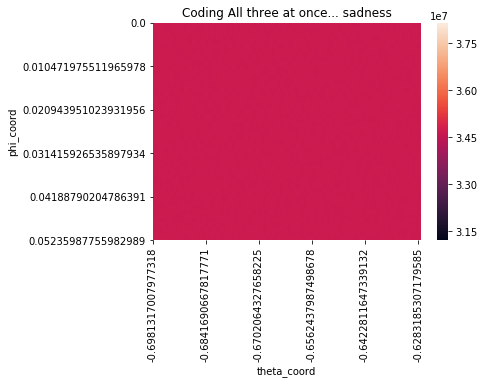

In [301]:
np.diag(obs.compute_normalization())

df_obs = pd.DataFrame.from_dict(np.asarray([x1,y1,np.real(np.diag(obs.compute_normalization()))]).T)
df_obs.columns = ['theta_coord','phi_coord','temp']
#df['Z_value'] = pd.to_numeric(df['temp'])



pivotted_obs= df_obs.pivot('phi_coord','theta_coord','temp')

#pivotted

ax = plt.axes()
sns.heatmap(pivotted_obs,ax=ax)
ax.set_title('Coding All three at once... sadness')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()






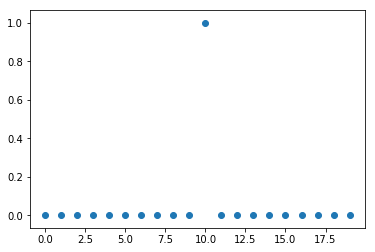

In [19]:
npix =len(obs.observable_coordinates())
tt = np.asarray(np.repeat(0,npix))
#imp = 10000*(signal.unit_impulse(npix, (npix/2)+npix/9)+signal.unit_impulse(npix,(npix/2)+(npix/9)+1))
imp = signal.unit_impulse(npix,'mid')

plt.scatter(range(npix),imp)

#plt.plot(np.real(obs.compute_Amat()[0]))

In [20]:
npix

20

In [21]:
x1 = np.zeros(npix)
y1 = np.zeros_like(x1)

for i in range(len(obs.observable_coordinates())):
    x1[i]= obs.observable_coordinates()[i,0]
    y1[i] = obs.observable_coordinates()[i,1]
    

#plt.scatter(x1,y1)
#plt.title('Observable Patch')#are these the only observable patches of the sky?? these are the only pixels that have data in them??


#the way x1 and y1 are printed out are by row. So the we have from left to right the bottom row then the next one up then the next etc... 


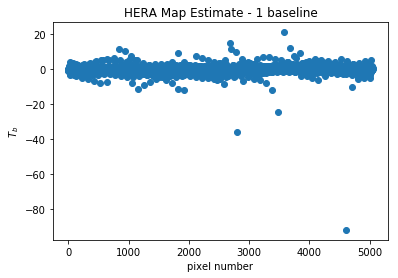

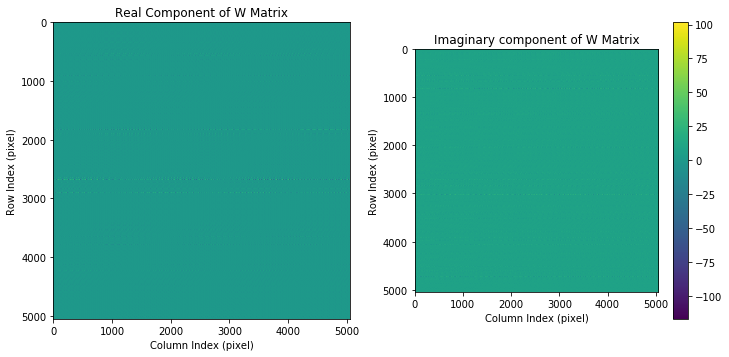

In [275]:

plt.scatter(np.arange(0,npix,1), np.real(obs.convolve_map(imp)))
plt.title("HERA Map Estimate - 1 baseline")
plt.xlabel("pixel number")
plt.ylabel("$T_b$")




fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

re = ax1.imshow(np.real(obs.W_matrix()))
ax1.set_title('Real Component of W Matrix')
ax1.set_ylabel('Row Index (pixel)')
ax1.set_xlabel('Column Index (pixel)')


im = ax2.imshow(np.imag(obs.W_matrix()))
ax2.set_title('Imaginary component of W Matrix')
ax2.set_ylabel('Row Index (pixel)')
ax2.set_xlabel('Column Index (pixel)')
cbar = fig.colorbar(re)

#we get a clean signal except for whhere there's spikey noise!! yay, I think. 

# A matrix

In [259]:
df_amat = pd.DataFrame.from_dict(np.array([x1,y1,np.real(obs.compute_Amat())]).T)
df_amat.columns = ['theta_coord','phi_coord','temp']
#df['Z_value'] = pd.to_numeric(df['temp'])



pivotted_amat= df_amat.pivot('phi_coord','theta_coord','temp')

#pivotted


sns.heatmap(pivotted_amat,cmap='RdBu')
plt.show()

 #I think the problem might be that this is in polar coordinates?? 



ValueError: Length mismatch: Expected axis has 1 elements, new values have 3 elements

In [22]:
obs.compute_Amat()

array([[9.61e-09, 0.00e+00, 0.00e+00],
       [0.00e+00, 9.61e-09, 0.00e+00],
       [0.00e+00, 0.00e+00, 9.61e-09]])

In [23]:
obs.compute_beam()

array([[9.60806100e-295, 9.60806100e-295, 9.60806100e-295,
        2.22557952e-294, 2.22557952e-294, 2.22557952e-294,
        2.50933390e-294, 2.50933390e-294, 2.50933390e-294,
        1.37715164e-294, 1.37715164e-294, 1.37715164e-294,
        1.88930425e-308, 1.88930425e-308, 1.88930425e-308,
        4.37632199e-308, 4.37632199e-308, 4.37632199e-308,
        4.93428926e-308, 4.93428926e-308],
       [4.93428926e-308, 2.70799536e-308, 2.70799536e-308,
        2.70799536e-308, 1.82804289e-322, 1.82804289e-322,
        1.82804289e-322, 4.19955799e-322, 4.19955799e-322,
        4.19955799e-322, 4.74303020e-322, 4.74303020e-322,
        4.74303020e-322, 2.56914136e-322, 2.56914136e-322,
        2.56914136e-322, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00

# Maps per Vis

In [89]:
obs.compute_vis(imp).shape #these are the 3 visibilities for each baseline. 

(3,)

In [63]:
obs.rotate_bls()

(3, 3)

In [107]:
obs.convolve_map(imp)


    

[array([[-0.70171546+0.59936262j, -0.57376268+0.72279771j,
         0.53998098+0.74837202j],
       [-0.02660008+0.98375535j,  0.23095869+0.95662962j,
         0.95298656-0.24555807j],
       [ 0.28827824+0.58400805j,  0.46438802+0.4566328j ,
         0.29589286-0.58018717j],
       ...,
       [-0.2406823 +0.42441008j,  0.47353267-0.11755298j,
         0.484918  -0.05391129j],
       [-0.23951845+0.32941701j,  0.39602763-0.09511452j,
         0.38200777-0.14126117j],
       [-0.24958368+0.28422551j,  0.36656447-0.09330939j,
         0.30819332-0.21930124j]]), array([[-0.74299299+0.54735871j, -0.62424623+0.67967403j,
         0.48477619+0.78525931j],
       [-0.09726235+0.97929678j,  0.16158015+0.9707595j ,
         0.96817555-0.17640368j],
       [ 0.2455425 +0.60322352j,  0.43035466+0.48884006j,
         0.33684199-0.55741117j],
       ...,
       [-0.27057409+0.40600683j,  0.48075908-0.08320217j,
         0.48753916-0.0189066j ],
       [-0.26258334+0.31134329j,  0.40184133-0.066394

array([-1.86304009+0.52857883j, -0.81895042+2.19638005j,
        0.42049513+1.6518849j , ..., -0.24504639+0.39324065j,
       -0.22022915+0.40280325j, -0.18629943+0.4356192j ])

# Sky map 

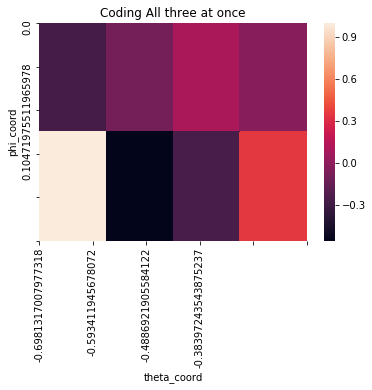

In [17]:
df_obs = pd.DataFrame.from_dict(np.asarray([x1,y1,np.real(obs.convolve_map(imp))]).T)
df_obs.columns = ['theta_coord','phi_coord','temp']
#df['Z_value'] = pd.to_numeric(df['temp'])



pivotted_obs= df_obs.pivot('phi_coord','theta_coord','temp')

#pivotted

ax = plt.axes()
sns.heatmap(pivotted_obs,ax=ax)
ax.set_title('Coding All three at once')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()



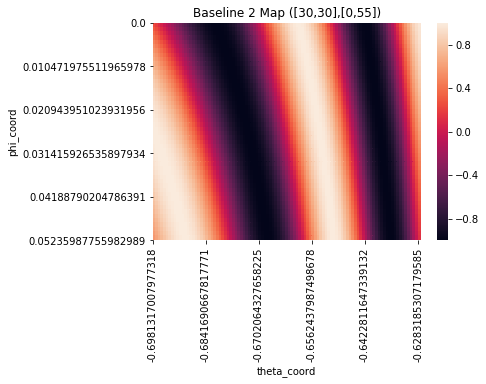

In [223]:
df_obs = pd.DataFrame.from_dict(np.asarray([x1,y1,np.real(obs2.convolve_map(imp))]).T)
df_obs.columns = ['theta_coord','phi_coord','temp']
#df['Z_value'] = pd.to_numeric(df['temp'])



pivotted_obs= df_obs.pivot('phi_coord','theta_coord','temp')

#pivotted

ax = plt.axes()
sns.heatmap(pivotted_obs,ax=ax)
ax.set_title('Baseline 2 Map ([30,30],[0,55])')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()




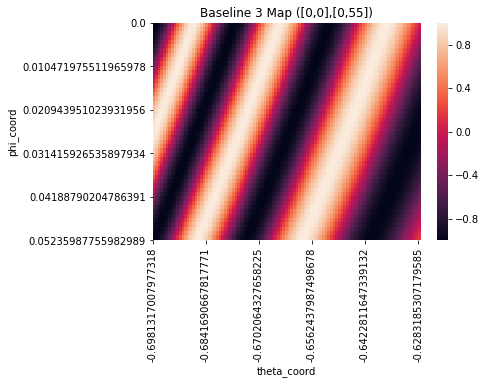

In [224]:


df_obs = pd.DataFrame.from_dict(np.asarray([x1,y1,np.real(obs3.convolve_map(imp))]).T)
df_obs.columns = ['theta_coord','phi_coord','temp']
#df['Z_value'] = pd.to_numeric(df['temp'])



pivotted_obs= df_obs.pivot('phi_coord','theta_coord','temp')

#pivotted

ax = plt.axes()
sns.heatmap(pivotted_obs,ax=ax)
ax.set_title('Baseline 3 Map ([0,0],[0,55])')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()




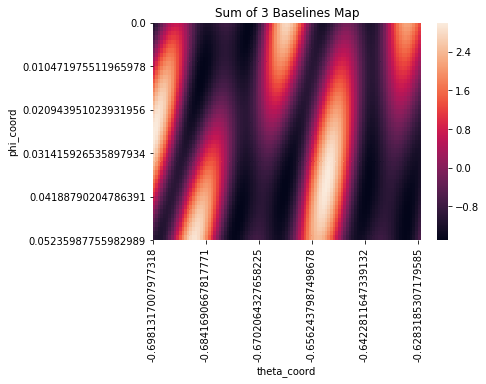

In [219]:
convolved = np.real(obs1.convolve_map(imp))+np.real(obs2.convolve_map(imp))+np.real(obs3.convolve_map(imp))

df_obs = pd.DataFrame.from_dict(np.asarray([x1,y1,convolved]).T)
df_obs.columns = ['theta_coord','phi_coord','temp']
#df['Z_value'] = pd.to_numeric(df['temp'])



pivotted_obs= df_obs.pivot('phi_coord','theta_coord','temp')

#pivotted

ax = plt.axes()
sns.heatmap(pivotted_obs,ax=ax)
ax.set_title('Sum of 3 Baselines Map')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()




Text(0.5,1,'histogram of pixel temperature - random field 41 bls')

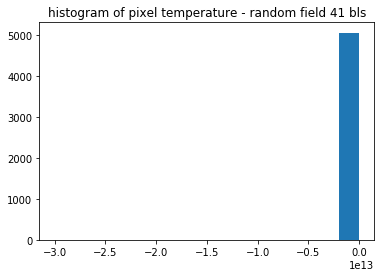

In [236]:
plt.hist(np.real(obs.convolve_map(tt)),15)
plt.title('histogram of pixel temperature - random field 41 bls')

In [238]:
np.histogram(np.real(obs.convolve_map(tt)),15)

(array([5049,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1]),
 array([-4.53650622e+03,  2.54419269e+13,  5.08838539e+13,  7.63257808e+13,
         1.01767708e+14,  1.27209635e+14,  1.52651562e+14,  1.78093489e+14,
         2.03535416e+14,  2.28977343e+14,  2.54419269e+14,  2.79861196e+14,
         3.05303123e+14,  3.30745050e+14,  3.56186977e+14,  3.81628904e+14]))

# Correlation histogram

# telescope array

Text(0.5,1,'3 dishes, 3 baslines ')

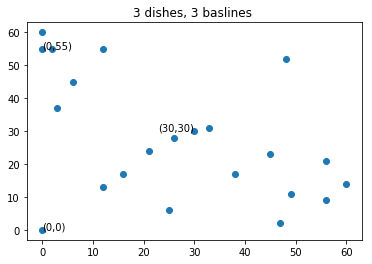

In [313]:


x = np.zeros(len(dishes))
y = np.zeros_like(x)

for i in range(len(dishes)):
    x[i]= dishes[i,0]
    y[i] = dishes[i,1]


plt.scatter(x,y)
plt.text(0,0,'(0,0)')
plt.text(0,55,'(0,55)')
plt.text(30,30,'(30,30)',horizontalalignment='right')
#plt.xlim(-160,160)
#plt.ylim(-150,150)
plt.title('3 dishes, 3 baslines ',)
#plt.gca().set_aspect('equal', adjustable='box')



In [66]:
#make the pixels smaller than the diffraction limited angular resolution so that you can resolve the features on the map. 
#make sure that you don't lose info by taking np.real 

In [574]:
#do the two baseline case analytically, what is the estimator trying to do. Check that with the code. 
#T(theta) = delta(theta (i.e. point source.))


#try aligning of of the baselines along u or v axis. Compute theta from that. 

3000000.0

In [ ]:
,[0,60],[60,0],[60,60],[30,60],[30,0],[0,30],[60,30],[15,60],[15,30],[15,0],[45,60],[45,30],[45,0],[0,15],[15,15],[30,15],[45,15],[60,15],[0,45],[15,45],[30,45],[45,45],[60,45]
,[0,60],[2,55],[47,2],[45,23],[56,21],[48,52],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55]

In [164]:
#How to make arrays look bigger!
A = np.ones(3)
B = np.random.rand(9).reshape(3,3)

np.dot(A,B), A*B

A[None,None,:]

array([[[1., 1., 1.]]])